# Comparing performance of two ML algorithms

In this notebook, performances of two different machine learning algorithms, Kernel Ridge Regression (KRR) and Random Forest Regression (RF), in predicting formation enthalpy of compounds using different crystal structure representations are compared. We also study how size of training set affect performance.

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import time
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from sklearn.utils import shuffle
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

Load data

In [ ]:
%%time
X_ward = pickle.load(open('./X_ward_nparray.pkl', 'rb'))
X_cm = pickle.load(open('./X_cm_nparray.pkl', 'rb'))
X_prdf = pickle.load(open('./X_prdf_nparray.pkl', 'rb'))

y = pickle.load(open('./y.pkl', 'rb'))

In [ ]:
print ("Shape of X_ward:", X_ward.shape)
print ("Shape of X_cm:", X_cm.shape)
print ("Shape of X_prdf:", X_prdf.shape)
print ("Shape of y:", y.shape)

Specify training set size

In [2]:
size = [10, 100, 1000, 10000, 30000]

In [ ]:
X = {"ward": X_ward, "cm": X_cm, "prdf": X_prdf}

### Build ML models 

In [ ]:
ft = ['ward', 'cm', 'prdf']

Initialize dictionaries to store MAE and time used

In [ ]:
mae_krr, mae_rfr, time_krr, time_rfr = dict.fromkeys(ft), dict.fromkeys(ft), dict.fromkeys(ft), dict.fromkeys(ft)
for i in ft:
    mae_krr[i], mae_rfr[i], time_krr[i], time_rfr[i] = [], [], [], []

Train model with increasing training set size

In [ ]:
for ft in X:
    for s in size:
        # Shuffle data
        X['ward'], X['cm'], X['prdf'], y = shuffle(X['ward'], X['cm'], X['prdf'], y)
        
        # Split data into training and testing set
        x_train, x_test = X[ft][:s], X[ft][-1000:]
        y_train, y_test = y[:s], y[-1000:]
        
# RANDOMFOREST: compute time used to train rfr
        start = time.perf_counter()
        
        # train rfr model
        rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        rfr.fit(x_train, y_train)
        
        # run rfr model
        y_pred = rfr.predict(x_test)
        
        finish = time.perf_counter()
        
        # compute mae and time for rfr model
        mae_rfr[ft].append(mean_absolute_error(y_pred, y_test))
        time_rfr[ft].append(finish-start)
        
# KERNELRIDGE: compute time used to train krr
        start = time.perf_counter()
        
        # train krr model
        krr = KernelRidge(kernel='laplacian', alpha=0.01, gamma=1.25e-05)
        krr.fit(x_train, y_train)
        
        # run rfr model
        y_pred = krr.predict(x_test)
        
        finish = time.perf_counter()
        
        # compute mae and time for krr model
        mae_krr[ft].append(mean_absolute_error(y_pred, y_test))
        time_krr[ft].append(finish-start)
        

Plot MAE of two ML algorithms using different crystal representations.

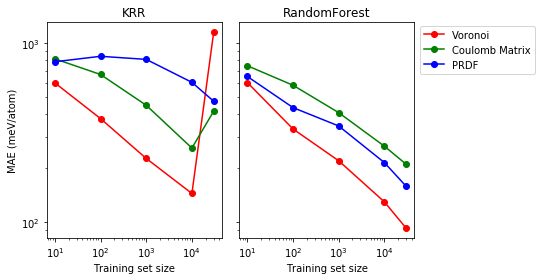

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.set_title("KRR")
ax2.set_title("RandomForest")

ax1.set_xlabel("Training set size")
ax1.set_ylabel("MAE (meV/atom)")

ax2.set_xlabel("Training set size")

ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_xscale("log")
ax2.set_yscale("log")

ax1.plot(size, [i*1e3 for i in mae_krr['ward']] , color='r', marker='o', label="Voronoi")
ax1.plot(size, [i*1e3 for i in mae_krr['cm']], color='g', marker='o', label="Coulomb Matrix")
ax1.plot(size, [i*1e3 for i in mae_krr['prdf']], color='b', marker='o', label="PRDF")

ax2.plot(size, [i*1e3 for i in mae_rfr['ward']], color='r', marker='o')
ax2.plot(size, [i*1e3 for i in mae_rfr['cm']], color='g', marker='o')
ax2.plot(size, [i*1e3 for i in mae_rfr['prdf']], color='b', marker='o')

fig.legend(bbox_to_anchor=(1.25, 0.9))
fig.tight_layout()

Finding: RandomForest generally has a lower prediction MAE than KRR. Voronoi tessellation representation generally yields a lower error than the other two representations (large MAE in KRR Voronoi representation may be due to outlier).

Plot time used of two ML algorithms using different crystal representations

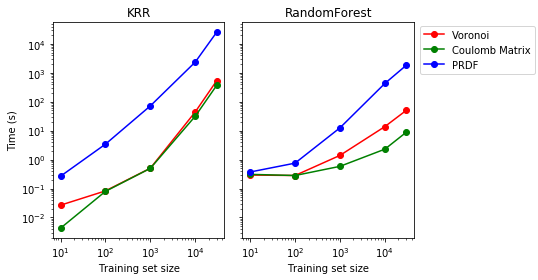

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.set_title("KRR")
ax2.set_title("RandomForest")

ax1.set_xlabel("Training set size")
ax1.set_ylabel("Time (s)")

ax2.set_xlabel("Training set size")

ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_xscale("log")
ax2.set_yscale("log")

ax1.plot(size, time_krr['ward'], color='r', marker='o', label="Voronoi")
ax1.plot(size, time_krr['cm'], color='g', marker='o', label="Coulomb Matrix")
ax1.plot(size, time_krr['prdf'], color='b', marker='o', label="PRDF")

ax2.plot(size, time_rfr['ward'], color='r', marker='o')
ax2.plot(size, time_rfr['cm'], color='g', marker='o')
ax2.plot(size, time_rfr['prdf'], color='b', marker='o')

fig.legend(bbox_to_anchor=(1.25, 0.9))
fig.tight_layout()

Finding: RandomForest takes a longer time for small dataset, but as size of training dataset increases, trainign time is shorter than KernelRidge.